# New Pooling Layers For Varying-Length Convolutional Networks

Here we'll try to use models that allow varying-length sequences without using recurrent layers.

This uses a method called K-max pooling, which is a max-pooling layer that, rather than selecting the top one out of some number of units, selects the k largest outputs from all the units in the previous layer. Citation: http://arxiv.org/abs/1404.2188

In [59]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Flatten, BatchNormalization
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle

## Loading Synthetic Data

Starting with alt-5' data for now

In [2]:
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

## Building a model

1st try: 100 1st layer conv filters with length 6, 64 2nd layer conv filters with length 6, 10 max pooling

2nd try: 100 1st layer conv filters with length 6, 5 max pooling

3rd try: 100 1st layer conv filters with length 10, 64 2nd layer conv filters with length 4, 5 max pooling

They both had similar results.

In [93]:
num_filters = [100,64,32]
filter_length = [10,4,6]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu', input_dim=4))
model1.add(keras_pooling.KMaxPooling(pooling_size=5))
model1.add(Flatten())
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))

In [94]:
l3 = model1.layers[3]

In [95]:
l3.input_shape

(None, None, 64)

In [96]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [97]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 1327s - loss: 0.5841 - acc: 1.0000 - val_loss: 0.5491 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 1318s - loss: 0.5481 - acc: 1.0000 - val_loss: 0.5395 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 1193s - loss: 0.5400 - acc: 1.0000 - val_loss: 0.5299 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 1190s - loss: 0.5346 - acc: 1.0000 - val_loss: 0.5260 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 1191s - loss: 0.5309 - acc: 1.0000 - val_loss: 0.5238 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 1187s - loss: 0.5282 - acc: 1.0000 - val_loss: 0.5215 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 1189s - loss: 0.5271 - acc: 1.0000 - val_loss: 0.5214 - val_acc: 1.0000
Epoch 8/50
212035/212035 

In [98]:
predictions = model1.predict(X1_test)

In [99]:
r2_score(Y2_test, predictions)

0.5958774575902821

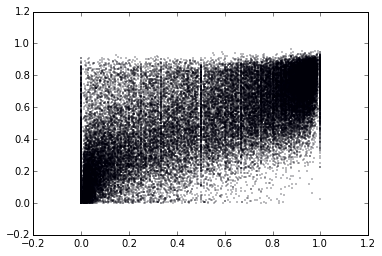

In [100]:
plt.scatter(Y2_test, predictions, s=0.1)
plt.show()

In [111]:
model1.save_weights('../data/convolutional-kmax-2.h5')
model_json = model1.to_json()
with open('../data/convolutional-kmax-20model.json', 'w') as f:
    f.write(model_json)

## Testing on Paper Data

the moment of truth...

In [28]:
table1 = pd.read_table('../data/mmc2.tsv')
wt_seqs = table1.WT_SEQ
mut_seqs = table1.MUT_SEQ
wt_seqs_encoded = [nn_utils.seq_to_array(x) for x in wt_seqs]
mut_seqs_encoded = [nn_utils.seq_to_array(x) for x in mut_seqs]
wt_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), wt_seqs_encoded)
mut_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), mut_seqs_encoded)

In [101]:
from keras import backend as K

expit = lambda x: 1./(1.+np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

get_3rd_layer_output_1 = K.function([model1.layers[0].input],
                                  [model1.layers[-2].get_output(train=False)])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [102]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [103]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]

In [104]:
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [105]:
r2_score(hal_pred, model_pred)

-0.074708368667460112

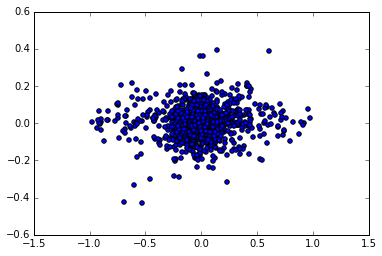

In [106]:
plt.scatter(hal_pred, model_pred)

In [107]:
score_mut = hal_pred_2 = []
model_pred_2 = []
actual = []
pos_or_neg = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)
        if h>=0 and m>=0:
            pos_or_neg.append(1)
        elif h<=0 and m<=0:
            pos_or_neg.append(0)

In [108]:
float(sum(pos_or_neg))/float(len(pos_or_neg))

0.44502617801047123

In [109]:
r2_score(actual, model_pred_2)

-0.060499057320662963

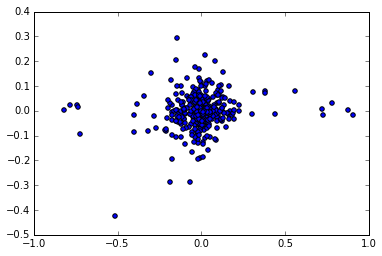

In [110]:
plt.scatter(actual, model_pred_2)

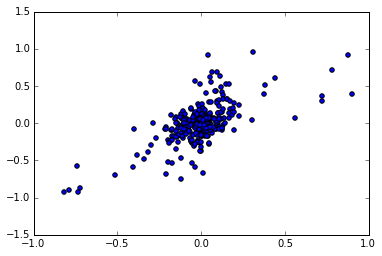

In [78]:
plt.scatter(actual, hal_pred_2)

In [79]:
r2_score(actual, hal_pred_2)

-0.13802471148011586

In [80]:
r2_score(hal_pred_2, actual)

0.43778175017456356

In [81]:
r2_score(model_pred_2, actual)

-2.1804617340773227

What is HAL doing that our models aren't doing?

1. They have specific features for the splice junctions.
2. They're trained on the alternative 3' data as well.

How do we replicate this with neural networks? How do we predict the effects of splice junctions?

Maybe we should try a simpler model? Maybe just one convolutional layer?

Meanwhile let's look at the convolutional filters.

In [82]:
model1.layers[0]

In [83]:
l1 = model1.layers[0]

In [84]:
filters = l1.get_weights()[0]

In [85]:
l1.get_weights()[1].shape # these are the biases

(100,)

In [86]:
filters[0,:,:]

array([[[ 0.00340114],
        [ 0.01409145],
        [ 0.05652529],
        [ 0.0729371 ],
        [-0.02654327],
        [-0.41919634]],

       [[ 0.01797695],
        [ 0.01605458],
        [ 0.01419568],
        [ 0.00271664],
        [ 0.15603916],
        [ 0.14889267]],

       [[-0.05470119],
        [-0.05954105],
        [-0.08474442],
        [-0.10964296],
        [-0.14625756],
        [-0.43486628]],

       [[ 0.00746209],
        [ 0.07449097],
        [ 0.08124859],
        [-0.01393758],
        [ 0.0828168 ],
        [ 0.23360863]]], dtype=float32)

In [87]:
print(filters[0,:,:])

[[[ 0.00340114]
  [ 0.01409145]
  [ 0.05652529]
  [ 0.0729371 ]
  [-0.02654327]
  [-0.41919634]]

 [[ 0.01797695]
  [ 0.01605458]
  [ 0.01419568]
  [ 0.00271664]
  [ 0.15603916]
  [ 0.14889267]]

 [[-0.05470119]
  [-0.05954105]
  [-0.08474442]
  [-0.10964296]
  [-0.14625756]
  [-0.43486628]]

 [[ 0.00746209]
  [ 0.07449097]
  [ 0.08124859]
  [-0.01393758]
  [ 0.0828168 ]
  [ 0.23360863]]]
